[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/yue-sun/generative-art/blob/master/05_friday/02_gan_art.ipynb)

# Generative Adversarial Network (GAN) Art
Generative Adversarial Networks, or GANs, consist of a pair of neural networks: a Generator and a Discriminator. The Generator’s job is to fool the Discriminator by creating realistic images from a random seed, while the Discriminator’s job is to distinguish the real from the fake images.

As the Generator improves its output to fool the Discriminator, it learns underlying patterns and motifs of the training data. Once trained, it can then generate completely new images that resemble real ones. Below is an illustration of the basic GAN architecture.

![gan.png](figs/gan.png)

For example, GANs can be used to generate artwork that emulates famous paintings! The results below were obtained following this blog post on [Generating Art using GANs](https://medium.com/jovianml/generating-art-with-gans-352ceef3d51f). We will base our implementation below on the same architecture.

![artwork.gif](figs/artwork.gif)

In this tutorial, we will use GANs to generate custom Pokemon. This tutorial was inspired by the [Monster GANs](https://medium.com/@yvanscher/using-gans-to-create-monsters-for-your-game-c1a3ece2f0a0) blog post and uses the [Pokemon Images Dataset](https://www.kaggle.com/kvpratama/pokemon-images-dataset) found on Kaggle. In the end, our result will look something like this:

![pokemon.gif](figs/pokemon.gif)

## Getting started
Since we're training a neural network, we'll want to use a GPU. To do so, go to ``Runtime > Select runtime type`` and ensure that GPU is selected from the dropdown menu, then hit save.

Then, we'll clone the Github repo to access some supporting files for import.

In [ ]:
!git clone https://github.com/yue-sun/generative-art.git
%cd generative-art/05_friday

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tqdm.notebook import tqdm
from IPython.display import HTML
#from google.colab import files

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

## Data loading and processing

In [217]:
# Specify data location and processing routine
dirname = "pokemon_data/"
batch_size = 128
image_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
augment = 2

In [215]:
from PIL import Image
from PIL import ImageChops
import os

files = next(os.walk("pokemon_data/png"))[2]
print(len(files))

419


(80, 80, 3)


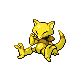

In [203]:
png = Image.open("pokemon_data/png/" + files[10]).convert('RGBA')
background = Image.new('RGBA', png.size, (255,255,255))

im = Image.alpha_composite(background, png).convert('RGB')
print(np.asarray(im).shape)
im

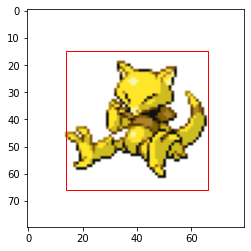

In [204]:
from matplotlib.patches import Rectangle
width, height = im.size
bg = Image.new(im.mode, im.size, (255,255,255))
diff = ImageChops.difference(im, bg)
diff = ImageChops.add(diff, diff, 2, -100)
xi, yi, xf, yf = diff.getbbox()
h, w = yf - yi, xf - xi
if h > w:
    d = (h - w)//2
    xi -= d
    xf += d
else:
    d = (w - h)//2
    yi -= d
    yf += d
h, w = yf - yi, xf - xi
rect = Rectangle((xi, yi), w, h, lw=1, ec='red', fc='none')

fig, ax = plt.subplots()
ax.imshow(im)
ax.add_patch(rect)

In [216]:
for f in files:
    png = Image.open("pokemon_data/png/" + f).convert('RGBA')
    bg = Image.new('RGBA', png.size, (255,255,255))
    im = Image.alpha_composite(bg, png).convert('RGB')
    width, height = im.size
    bg = Image.new(im.mode, im.size, (255,255,255))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2, -100)
    xi, yi, xf, yf = diff.getbbox()
    h, w = yf - yi, xf - xi
    if h > w:
        d = (h - w)//2
        xi -= d
        xf += d
    else:
        d = (w - h)//2
        yi -= d
        yf += d
    im = im.crop((xi, yi, xf, yf))
    im.save("pokemon_data/gen3/" + f[:-4] + ".jpg", 'JPEG', quality=95)

In [219]:
png = Image.open("pokemon_data/gen4/100.jpg")
print(np.asarray(png).shape)
png

(30, 30, 3)


In [220]:
# Convert images to tensors of the same size and normalize
transform_ds = transforms.Compose([transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = ImageFolder(root=dirname, transform=transform_ds)
print(len(train_ds))

1646


In [221]:
# Augment dataset by performing random perspective distortions and horizontal flips of the images
augment_ds = transforms.Compose([transforms.Resize(image_size),
                                 transforms.CenterCrop(image_size),
                                 transforms.ToTensor(),
                                 transforms.Normalize(*stats),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomPerspective(distortion_scale=0.2, p=1., fill=1.,
                                    interpolation=transforms.InterpolationMode.NEAREST)
                                   ])

datasets = [train_ds]
for i in range(augment):
    datasets += [ImageFolder(root=dirname, transform=augment_ds)]
train_ds = ConcatDataset(datasets)
print(len(train_ds))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

4938


In [222]:
# Helper functions to visualize image data
def denorm(img_tensors):
    return img_tensors*stats[1][0] + stats[0][0]

def show_images(images, nmax=64, figsize=(8,8)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64, figsize=(8,8)):
    for images, _ in dl:
        show_images(images, nmax, figsize)
        break

torch.Size([3, 64, 64])


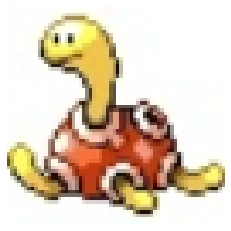

In [223]:
# Show an example image
image, _ = train_ds[np.random.randint(len(train_ds))]
print(image.size())
plt.imshow(denorm(image.permute(1,2,0)))
plt.axis('off')
plt.show()

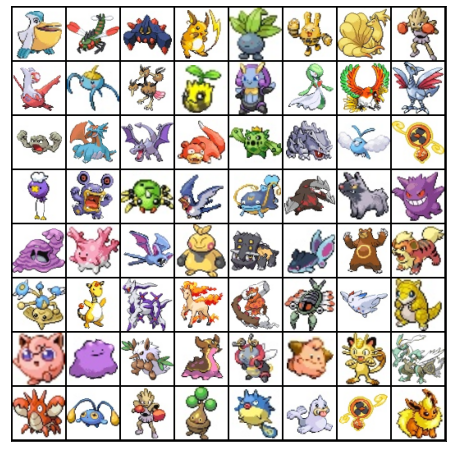

In [224]:
# Show an example batch
show_batch(train_dl)

## Moving to GPU

In [41]:
# Helper functions to move data and models to a GPU if available
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [42]:
# Select device and move data to device
device = get_default_device()
print(device)
train_dl = DeviceDataLoader(train_dl, device)

cpu


## Building the GAN

In [43]:
# Build discriminator model
modules = []
in_channels = 3
out_channels = 64
for i in range(int(np.log2(image_size))-2):
    modules.append(nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True),
    ))
    in_channels = out_channels
    out_channels *= 2

modules.append(nn.Sequential(
    nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
))

discriminator = nn.Sequential(*modules)
print(discriminator)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_sl

In [44]:
# Build generator model
latent_size = 128
modules = []
out_channels = in_channels
modules.append(nn.Sequential(
    nn.ConvTranspose2d(latent_size, out_channels, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(out_channels),
    nn.ReLU(True),
))
in_channels = out_channels
out_channels //= 2

for i in range(int(np.log2(image_size))-3):
    modules.append(nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True),
    ))
    in_channels = out_channels
    out_channels //= 2

modules.append(nn.Sequential(
    nn.ConvTranspose2d(in_channels, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh(),
))

generator = nn.Sequential(*modules)
print(generator)

Sequential(
  (0): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (4): Sequential(
    (0): ConvTranspose2d(64, 3,

torch.Size([128, 3, 64, 64])


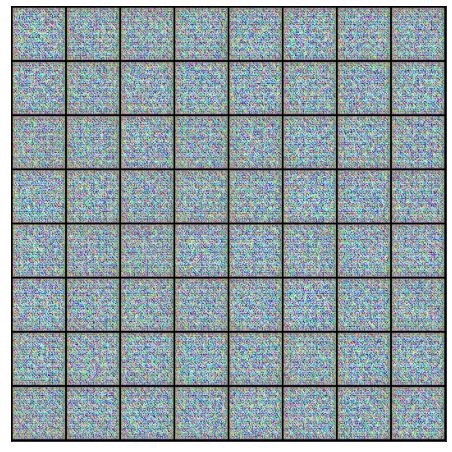

In [45]:
# Plot the output of an untrained generator
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [46]:
# Move models to device
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

## Training routines

In [47]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score
    
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

def show_samples(latent_tensors, figsize=(8,8)):
    fake_images = generator(latent_tensors)
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=8).permute(1, 2, 0))
    plt.show()

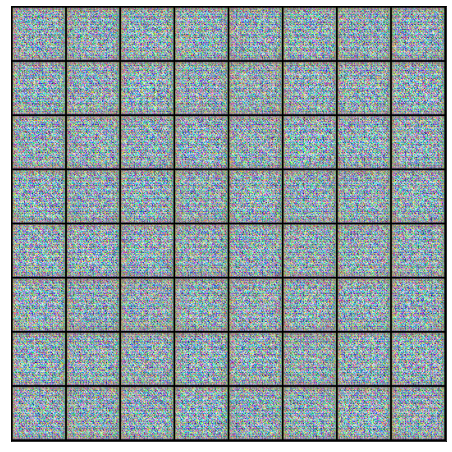

In [48]:
# Define a fixed random sample to evaluate during training
fixed_size = int(batch_size//2)
fixed_latent = torch.randn(fixed_size, latent_size, 1, 1, device=device)
show_samples(fixed_latent);

## Training!

In [49]:
def fit(epochs, lr):
    torch.cuda.empty_cache()
    # Intermediate results
    checkpoint = 5
    fake_images = torch.zeros(epochs//checkpoint, fixed_size, *image.shape)

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    i = 0
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Show generated images
        if (epoch+1)%checkpoint == 0:
            show_samples(fixed_latent)
            fake_images[i] = denorm(generator(fixed_latent).cpu().detach())
            i += 1
            
            results = {
                'history': {
                    'losses_g': losses_g,
                    'losses_d': losses_d,
                    'real_scores': real_scores,
                    'fake_scores': fake_scores,
                },
                'discriminator': discriminator.state_dict(),
                'generator': generator.state_dict(),
            }
            with open('my-model.torch', 'wb') as f:
                torch.save(results, f)
    
    return fake_images

In [50]:
# Specify the learning rate and number of epochs (iterations through the full dataset)
lr = 0.001
epochs = 150

In [51]:
# Train the networks
fake_images = fit(epochs, lr)

  0%|          | 0/36 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11feeed30>
Traceback (most recent call last):
  File "/Users/ninaandrejevic/anaconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1508, in __del__
    self._shutdown_workers()
  File "/Users/ninaandrejevic/anaconda3/envs/py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1472, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/ninaandrejevic/anaconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/ninaandrejevic/anaconda3/envs/py39/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/ninaandrejevic/anaconda3/envs/py39/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/Users/ninaandrejevic/anaconda3/envs/py39/lib/python3.9/sel

KeyboardInterrupt: 

In [ ]:
# Read out the intermediate losses of saved model
history = torch.load('my-model.torch')['history']
#history = torch.load('gan-art.torch')['history']
losses_g, losses_d, real_scores, fake_scores = history.values()

In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
ax1.plot(losses_d)
ax1.plot(losses_g)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(['Discriminator', 'Generator'], frameon=False, fontsize=12)
ax1.set_title('Losses', fontsize=16)

ax2.plot(real_scores)
ax2.plot(fake_scores)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.legend(['Real', 'Fake'], frameon=False, fontsize=12)
ax2.set_title('Scores', fontsize=16)
plt.show()

In [ ]:
# Load pre-trained models
discriminator.load_state_dict(torch.load('gan-art.torch')['discriminator'])
generator.load_state_dict(torch.load('gan-art.torch')['generator'])

In [ ]:
# Plot the output of a trained generator on random seeds
xb = torch.randn(batch_size, latent_size, 1, 1)
show_images(generator(xb.to(device)).cpu(), figsize=(10,10))

In [ ]:
# Create an animation of the evolution of fake images during training
def animate_results(dl, fake_images, figsize=(16,8)):
    frames = fake_images.shape[0]
    nmax = fake_images.shape[1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.set_xticks([]); ax1.set_yticks([])
    ax2.set_xticks([]); ax2.set_yticks([])

    for images, _ in dl:
        ax1.imshow(make_grid(denorm(images.detach().cpu()[:nmax]), nrow=8).permute(1, 2, 0))
        break

    im = ax2.imshow(make_grid(fake_images[0], nrow=8).permute(1, 2, 0))

    ax1.set_title('Example Training Batch', fontsize=18)
    ax2.set_title('Example Fake Images  |   Epochs: 5', fontsize=18)

    def animate(i):
        im.set_array(make_grid(fake_images[i], nrow=8).permute(1, 2, 0))
        ax2.set_title('Example Fake Images  |   Epochs: ' + str(5*(i + 1)), fontsize=18)
        return im,

    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=500, blit=True)
    plt.close(fig)
    return ani

In [ ]:
# Create animation
ani = animate_results(train_dl, fake_images)

# Display animation
HTML(ani.to_html5_video())

In [ ]:
# Save animation as a gif and download
ani.save('pokemon.gif', writer='pillow', fps=2)
files.download('pokemon.gif')